# Problem Statement
> Portuguese banking institution does direct marketing campaigns.The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

  >>The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# Define Evaluation Metrics
>1. Acuracy
2. Recall
3. F1 Score
4. Confusion Matrix

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn==1.7.1

Note: you may need to restart the kernel to use updated packages.


In [6]:
import sklearn
print(sklearn.__version__)

1.7.1


In [7]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade lightgbm


Note: you may need to restart the kernel to use updated packages.


# Importing Neccessary libraries

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import imblearn
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import joblib
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve , average_precision_score
from pickle import dump

In [171]:
import matplotlib
print(lgb.__version__)

4.6.0


In [11]:
warnings.filterwarnings("ignore")
pd.set_option("display.precision" , 2)
plt.style.use("ggplot")
sns.set_style("whitegrid")
random.seed(42)

# Data Collection

In [13]:
import pandas as pd

# Read CSV with semicolon separator and quotes
bank_full = pd.read_csv("bank-full[1].csv", sep=";")

print(bank_full.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [14]:
bank_full.shape

(45211, 17)

In [15]:
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [16]:
bank_full.duplicated().any()

False

In [17]:
bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [18]:
num_cols = bank_full.select_dtypes(include=np.number).columns
num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

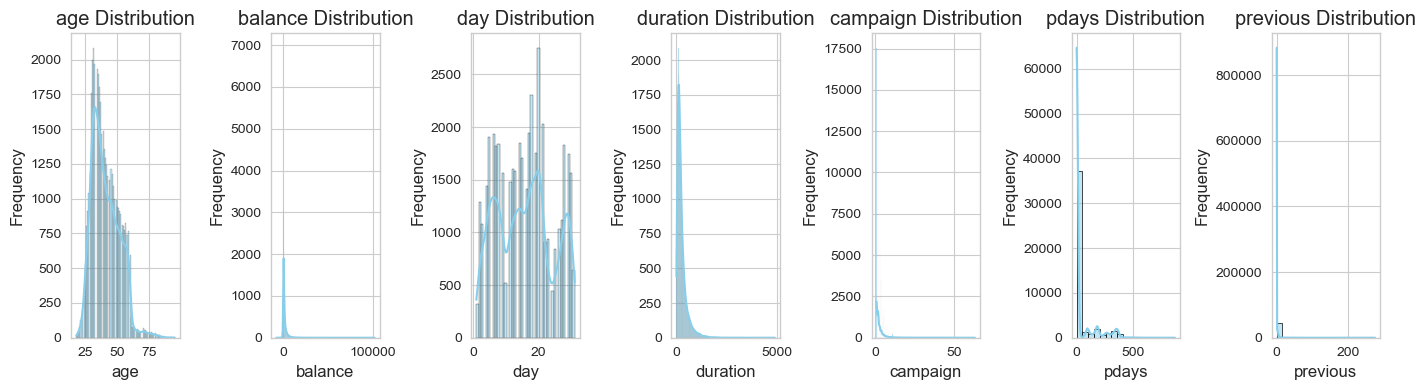

In [19]:
#sns.boxplot(bank_full[num_cols])
#bank_full[num_cols].plot(kind = "box")
n = len(num_cols)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(2*n, 4))
for i, col in enumerate(num_cols):
    sns.histplot(bank_full[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

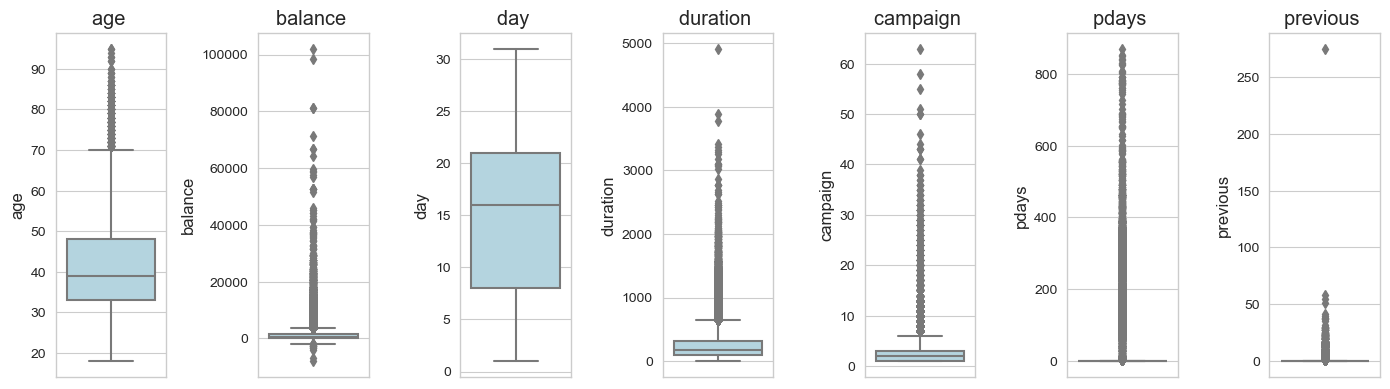

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(2*n, 4))

for i, col in enumerate(num_cols):
    sns.boxplot(y=bank_full[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f'{col} ')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [21]:
df = bank_full.copy()

In [22]:
# balance
qh25, qh50, qh75 = np.percentile(df['balance'], [25,50,75])
iqrh = qh75-qh25
minh = qh25 - 1.5*iqrh
maxh = qh75 + 1.5*iqrh

#Choose the data inside IQR
df = df[(df['balance'] > minh) & (df['balance'] < maxh)]

In [23]:
# Weight
qw25, qw50, qw75 = np.percentile(df['age'], [25,50,75])
iqrw = qw75-qw25
maxw = qw75 + 1.5*iqrw

#Choose the data inside IQR (only data below the max value of weight since the data is right-skewed)
df = df[df['age'] < maxw]

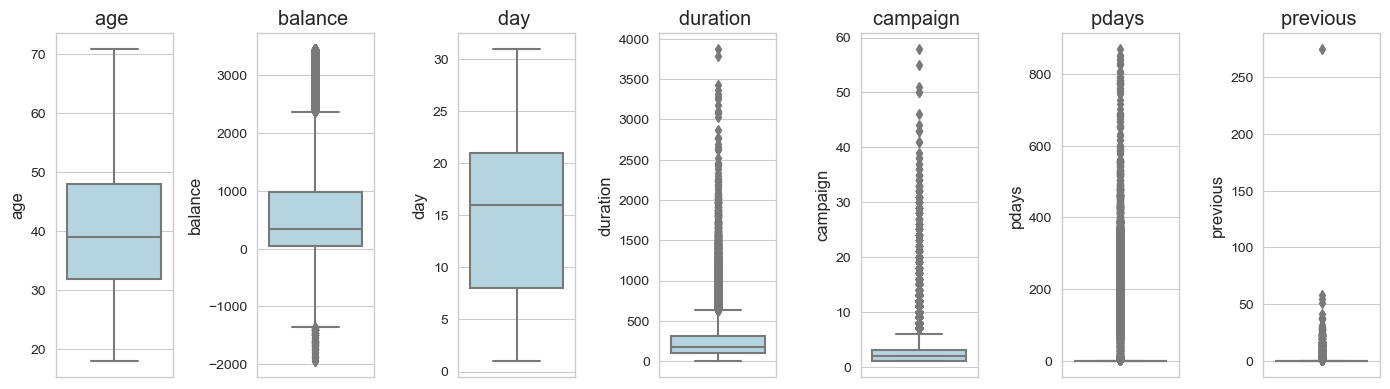

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(2*n, 4))

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f'{col} ')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

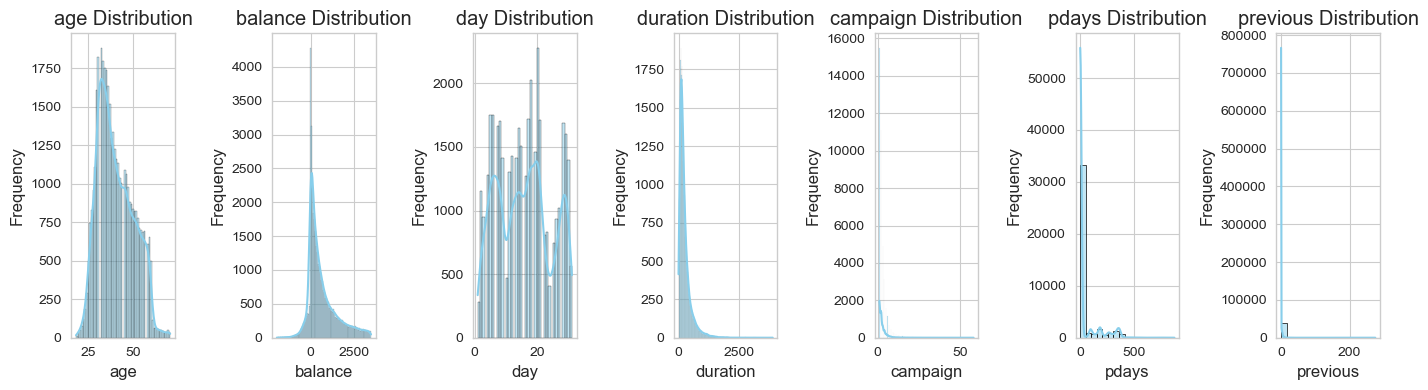

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(2*n, 4))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: xlabel='y'>

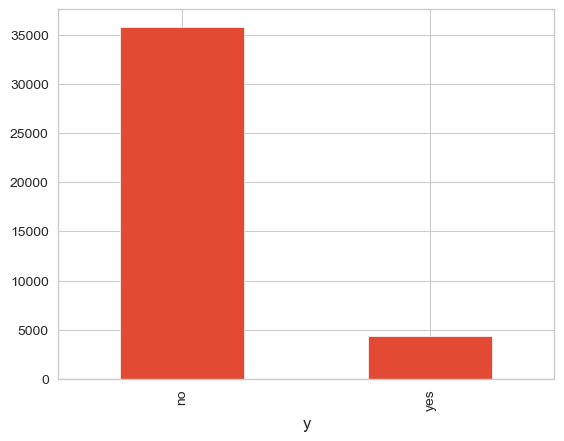

In [26]:
df["y"].value_counts().plot(kind = "bar")

# Feature Engineering

In [28]:
df["marital"] = bank_full["marital"]

In [29]:
df["default"] = df["default"].replace({"yes":1 , "no":0})
df["y"] = df["y"].replace({"yes":1 , "no":0})
df["housing"] = df["housing"].replace({"yes":1 , "no":0})
df["loan"] = df["loan"].replace({"yes":1 , "no":0})
order = ["unknown" , "primary" , "secondary" , "tertiary"]
encoder = OrdinalEncoder(categories=[order])
df['education_encoded'] = encoder.fit_transform(df[['education']])


In [30]:
dump(encoder, open("encoder.pkl", "wb"))

In [31]:
df["marital_encoded"] = df["marital"].replace({"married":1 , "single":0 , "divorced":2})

In [32]:
df.drop(columns=["poutcome"] , inplace = True)
df.drop(columns=["job"] , inplace = True)
df.drop(columns=["contact"] , inplace = True)
df.drop(columns=["month"] , inplace = True)
df.drop(columns=["marital"] , inplace = True)
df.drop(columns=["education"] , inplace = True)

In [33]:
df.corr()["y"].drop('y')

age                 -0.02
default             -0.02
balance              0.09
housing             -0.13
loan                -0.06
day                 -0.03
duration             0.40
campaign            -0.07
pdays                0.10
previous             0.09
education_encoded    0.06
marital_encoded     -0.05
Name: y, dtype: float64

In [34]:
mott = df.corr()

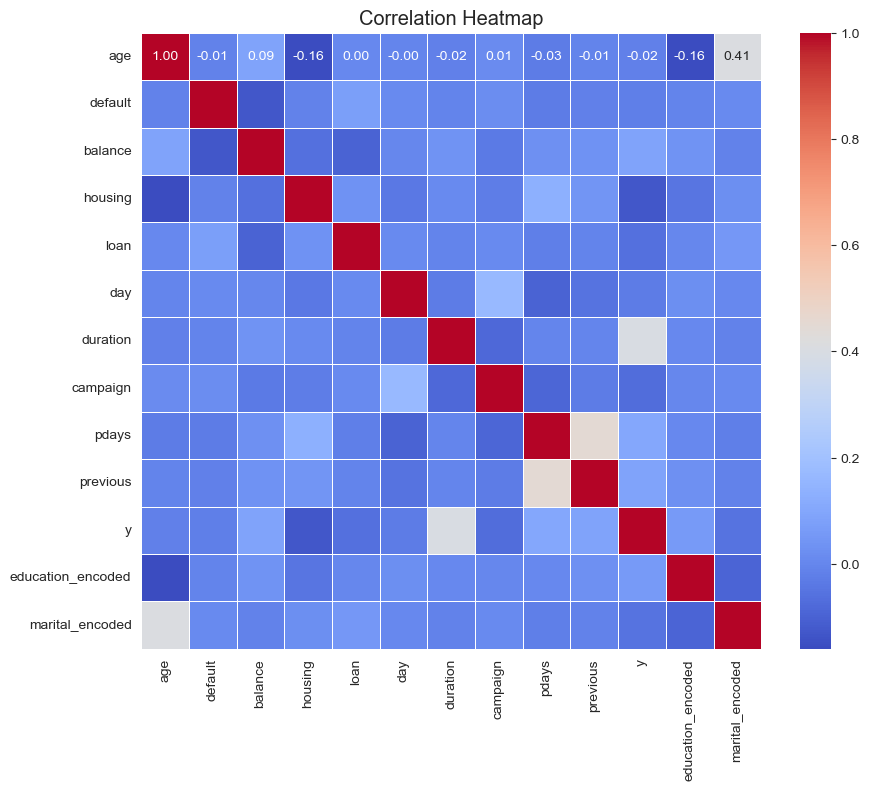

In [35]:
plt.figure(figsize=(10, 8))  # Optional: adjust size
sns.heatmap(mott, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [36]:
df.drop(columns = ["age" ,"default" , "housing" , "loan" , "day" , "campaign" , "marital_encoded"] , inplace = True)

In [37]:
with open("df.pkl", 'wb') as file:
    dump(df, file)

In [38]:
df.head()

,balance,duration,pdays,previous,y,education_encoded
0,2143,261,-1,0,0,3.0
1,29,151,-1,0,0,2.0
2,2,76,-1,0,0,2.0
3,1506,92,-1,0,0,0.0
4,1,198,-1,0,0,0.0


In [39]:
# Suppose your target column is named 'target'
df_target_1 = df[df['y'] == 1]

# Display first few records
print(df_target_1.head())


     balance  duration  pdays  previous  y  education_encoded
83      2343      1042     -1         0  1                2.0
86        45      1467     -1         0  1                2.0
87      1270      1389     -1         0  1                2.0
129     2476       579     -1         0  1                2.0
168      184       673     -1         0  1                3.0


In [40]:
x = df.drop(columns = ["y"])
y = df["y"]

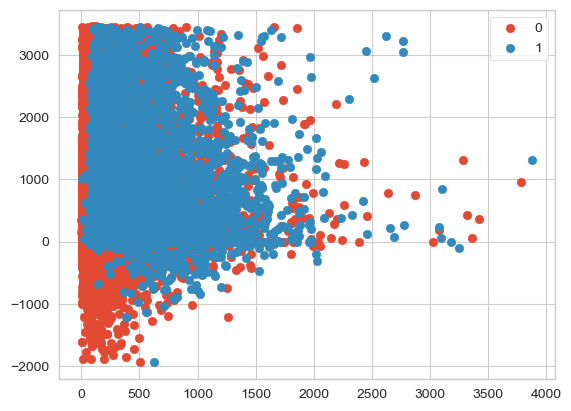

In [41]:
counter = Counter(y)

for label, _  in counter.items():
  row_ix = np.where(y == label)[0]
  plt.scatter(x.iloc[row_ix]["duration"], x.iloc[row_ix]["balance"], label=str(label))
plt.legend()
plt.show()


Counter({0: 35769, 1: 4376})


<Axes: >

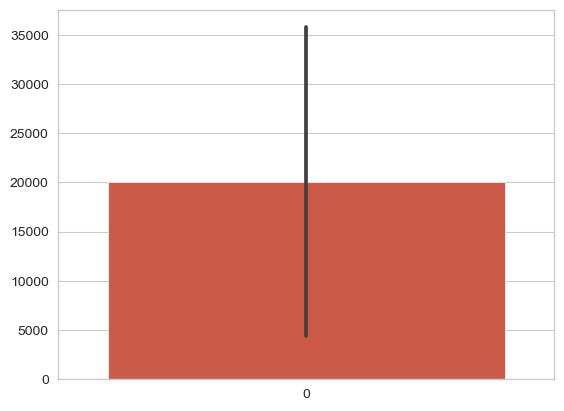

In [42]:
print(Counter(y))
sns.barplot(y.value_counts())

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
y_pred = rf.predict(X_test)

Accuracy: 0.8904

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7145
           1       0.50      0.31      0.38       884

    accuracy                           0.89      8029
   macro avg       0.71      0.63      0.66      8029
weighted avg       0.87      0.89      0.88      8029



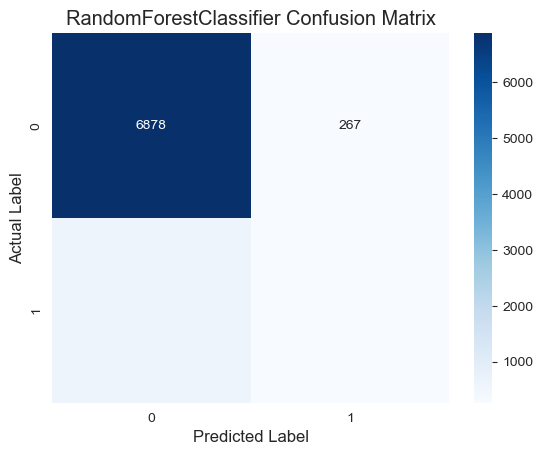

In [46]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
cm = confusion_matrix(y_test, y_pred)
#print(cm)
print(classification_report(y_test, y_pred))
sns.heatmap(cm , annot = True , fmt = "d" , cmap = "Blues")
plt.title('RandomForestClassifier Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


PR-AUC (Average Precision): 0.392


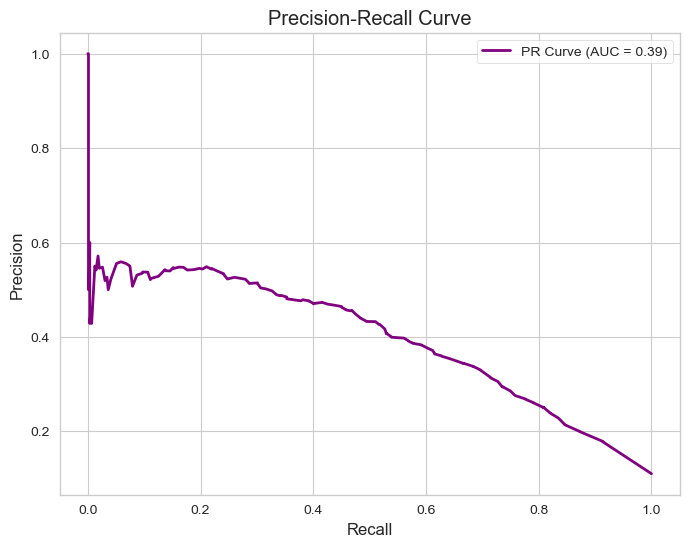

In [47]:
y_prob = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute PR-AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_prob)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


Robust Logistic Regression Accuracy: 0.8977

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7145
           1       0.63      0.18      0.28       884

    accuracy                           0.90      8029
   macro avg       0.77      0.58      0.61      8029
weighted avg       0.88      0.90      0.87      8029



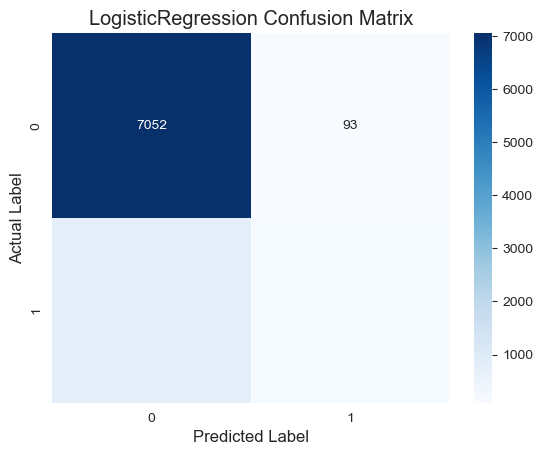

In [48]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create Logistic Regression with regularization (L2 by default)
model_lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)

# Train the model
model_lr.fit(X_train, y_train)

# Predict on test data
y_pred = model_lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Robust Logistic Regression Accuracy: {accuracy:.4f}")
#print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
sns.heatmap(conf_matrix , annot = True , fmt = "d" , cmap = "Blues")
plt.title('LogisticRegression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

PR-AUC (Average Precision): 0.445


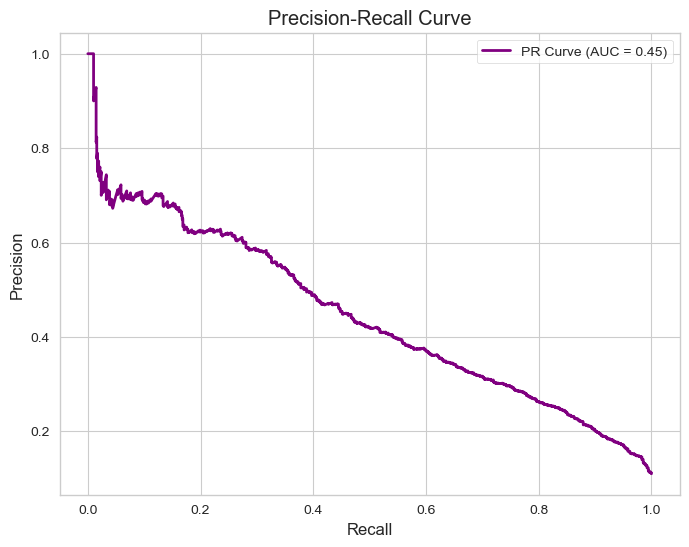

In [49]:
y_prob = model_lr.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute PR-AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_prob)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


### Handling Imbalence using Oversampling minarity class (SMOTE)

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [52]:
def find_best_threshold(y_test,y_proba):
  best_threshold = 0
  best_f1 = 0
  for t in thresholds:
      y_pred = (y_proba >= t).astype(int)
      f1 = f1_score(y_test, y_pred)
      if f1 > best_f1:
         best_f1 = f1
         best_threshold = t

  print(f"Best Threshold: {best_threshold:.3f}")
  print(f"Best F1 Score: {best_f1:.3f}")
  return best_threshold

In [53]:
from xgboost import XGBClassifier

# Create model
xgb = XGBClassifier(
    use_label_encoder=False,     # to suppress warning
    eval_metric='logloss',       # necessary since use_label_encoder is False
    random_state=42
)

# Train on SMOTE-balanced data
xgb.fit(X_train_res, y_train_res)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Best Threshold: 0.654
Best F1 Score: 0.496
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7145
           1       0.46      0.54      0.50       884

    accuracy                           0.88      8029
   macro avg       0.70      0.73      0.71      8029
weighted avg       0.89      0.88      0.88      8029

PR-AUC (Average Precision): 0.299


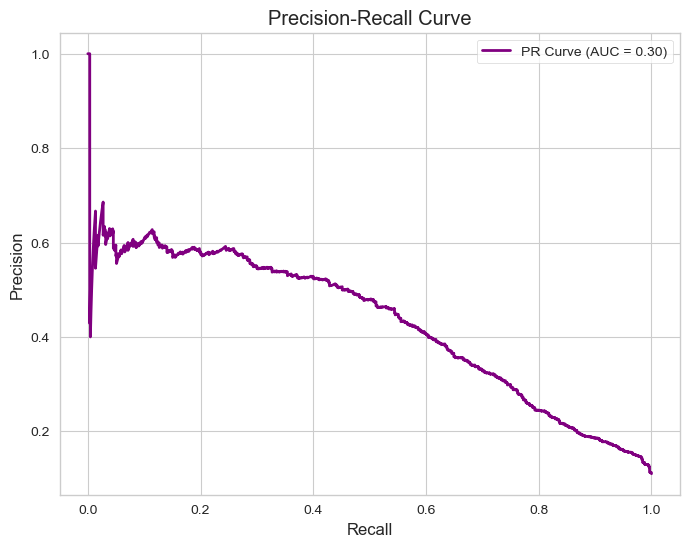

In [54]:
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

best_threshold = find_best_threshold(y_test ,y_proba_xgb )

y_pred_xgb = (y_proba_xgb >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_xgb))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = average_precision_score(y_test, y_pred_xgb)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


In [55]:
ada_1 = AdaBoostClassifier(
    n_estimators=100,     # number of weak learners
    learning_rate=0.5,    # controls contribution of each learner
    random_state=42
)
ada_1.fit(X_train_res, y_train_res)

,estimator,None
,n_estimators,100
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42


Best Threshold: 0.553
Best F1 Score: 0.502
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      7145
           1       0.43      0.61      0.50       884

    accuracy                           0.87      8029
   macro avg       0.69      0.75      0.71      8029
weighted avg       0.89      0.87      0.88      8029

PR-AUC (Average Precision): 0.303


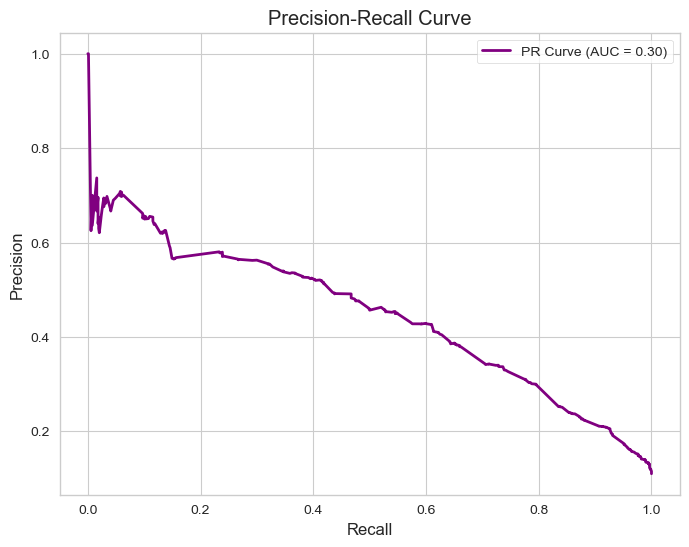

In [56]:
y_pred = ada_1.predict(X_test)
y_scores = ada_1.predict_proba(X_test)[:, 1]  # Probability for class=1

best_threshold = find_best_threshold(y_test ,y_scores )

y_pred_x = (y_scores >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_x))

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_pred_x)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [57]:
model_lgb = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    n_estimators=100,       # Number of boosting rounds (trees)
    learning_rate=0.1,      # Step size
    max_depth=-1,           # No limit on depth
    random_state=42
)
model_lgb.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 28624, number of negative: 28624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 57248, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Accuracy: 0.8273757628596339

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7145
           1       0.36      0.71      0.48       884

    accuracy                           0.83      8029
   macro avg       0.66      0.78      0.69      8029
weighted avg       0.89      0.83      0.85      8029



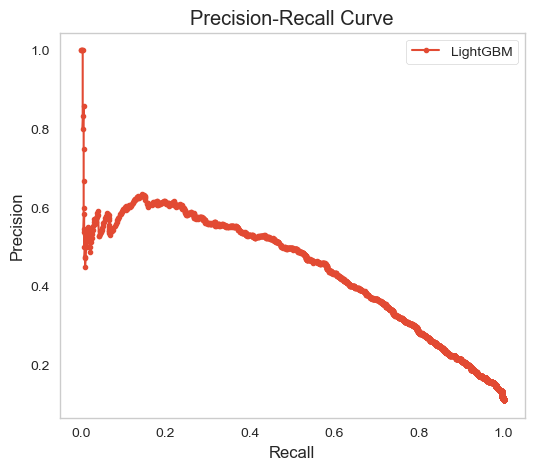

In [58]:
y_pred = model_lgb.predict(X_test)

# Predictions (probabilities for precision-recall curve)
y_prob = model_lgb.predict_proba(X_test)[:, 1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report (Precision, Recall, F1-score, Support)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [59]:
llr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit on SMOTE-balanced data
llr.fit(X_train_res, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Best Threshold: 0.659
Best F1 Score: 0.473
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      7145
           1       0.32      0.70      0.44       884

    accuracy                           0.80      8029
   macro avg       0.64      0.76      0.66      8029
weighted avg       0.89      0.80      0.83      8029

PR-AUC (Average Precision): 0.258


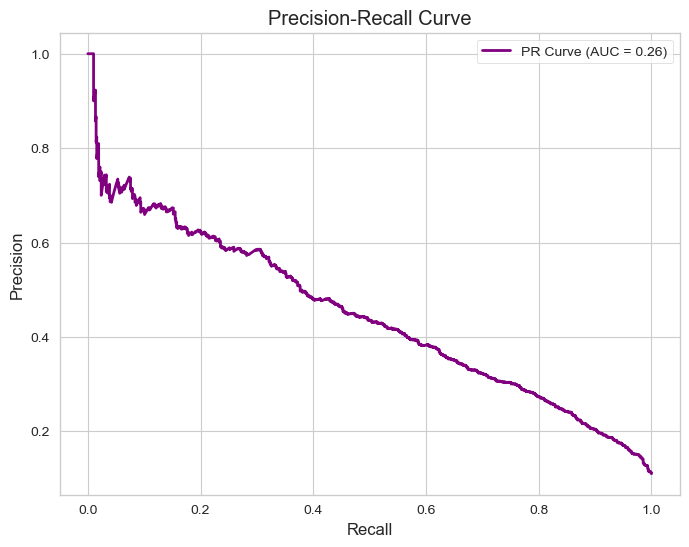

In [60]:
y_proba_lr = llr.predict_proba(X_test)[:, 1]
best_threshold = find_best_threshold(y_test ,y_proba_lr )
y_pred_lr = (y_proba_lr >= 0.5).astype(int)
print(classification_report(y_test, y_pred_lr))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)
pr_auc = average_precision_score(y_test, y_pred_lr)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

### Handling Imbalence using Undersampling majority class (RandomUnderSampler)

In [62]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [63]:
xgb_1 = XGBClassifier(
    use_label_encoder=False,     # to suppress warning
    eval_metric='logloss',       # necessary since use_label_encoder is False
    random_state=42
)

# Train on SMOTE-balanced data
xgb_1.fit(X_resampled, y_resampled)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Best Threshold: 0.737
Best F1 Score: 0.509
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      7145
           1       0.44      0.61      0.51       884

    accuracy                           0.87      8029
   macro avg       0.69      0.75      0.72      8029
weighted avg       0.89      0.87      0.88      8029

PR-AUC (Average Precision): 0.309


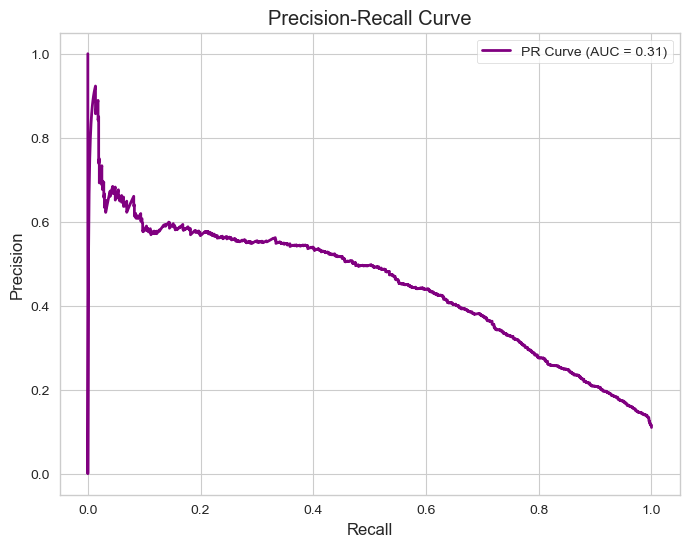

In [64]:
y_proba_xgb_1 = xgb_1.predict_proba(X_test)[:, 1]

best_threshold = find_best_threshold(y_test ,y_proba_xgb_1 )

y_pred_xgb_1 = (y_proba_xgb_1 >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_xgb_1))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb_1)
pr_auc = average_precision_score(y_test, y_pred_xgb_1)

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [65]:
'''with open("modell.pkl", "wb") as f:
    dump(ada_1, f)'''

'with open("modell.pkl", "wb") as f:\n    dump(ada_1, f)'

In [66]:
'''with open("xgb_model.pkl", "wb") as f:
    dump(xgb, f)'''

'with open("xgb_model.pkl", "wb") as f:\n    dump(xgb, f)'

In [67]:
'''with open("xgb_modell.pkl", "wb") as f:
    dump(xgb_1, f)'''

'with open("xgb_modell.pkl", "wb") as f:\n    dump(xgb_1, f)'

In [68]:
'''xgb_1.save_model("xgb_modell.json")'''

'xgb_1.save_model("xgb_modell.json")'

In [149]:
joblib.dump(xgb, 'model.pkl')

['model.pkl']

In [69]:
xgb.save_model("xgb.json")   # or .bst

In [71]:
new = pd.DataFrame([{"balance" : 2 , "duration" : 76 , "pdays" : -1 ,"previous" : 0 , "education" : "secondary"}])

new["education_encoded"] = encoder.transform(new[["education"]])

new.drop(columns = ["education"] , inplace = True)

predicted = xgb.predict(new)

In [72]:
predicted[0]

0

In [73]:
predicted = xgb_1.predict(new)

In [74]:
predicted[0]

1